In [34]:
import numpy as np
from kronvec import kron_diag as get_diag_paired
# from Utilityfunctions import reachable_states
import itertools
from scipy.linalg.blas import dcopy, dscal, daxpy

n = 5
np.random.seed(2)
log_theta = 2 * np.random.random(size=(n + 1, n + 1)) - 1
tau1, tau2 = np.random.random(2) * 2

In [32]:
def get_diag_unpaired(log_theta, state: np.array) -> np.array:
    """This returns the diagonal of the restricted rate matrix of the metMHN's Markov chain.

    Args:
        state (np.array): Binary unpaired state vector, dtype must be int32. This is the vector according
        to which state space restriction will be performed. Shape (n,) with n the number of events including
        seeding.

    Returns:
        np.array: Diagonal of the restricted rate matrix. Shape (2^k,) with k the number of 1s in state.
    """
    k = state.sum()
    nx = 1 << k
    n = log_theta.shape[0]
    diag = np.zeros(nx)
    subdiag = np.zeros(nx)

    for i in range(n):

        current_length = 1
        subdiag[0] = 1
        # compute the ith subdiagonal of Q
        for j in range(n):
            if state[j]:
                exp_theta = np.exp(log_theta[i, j])
                if i == j:
                    exp_theta *= -1
                    dscal(n=current_length, a=exp_theta, x=subdiag, incx=1)
                    dscal(n=current_length, a=0,
                            x=subdiag[current_length:], incx=1)
                else:
                    dcopy(n=current_length, x=subdiag, incx=1,
                            y=subdiag[current_length:], incy=1)
                    dscal(n=current_length, a=exp_theta,
                            x=subdiag[current_length:], incx=1)

                current_length *= 2

            elif i == j:
                exp_theta = - np.exp(log_theta[i, j])
                dscal(n=current_length, a=exp_theta, x=subdiag, incx=1)

        # add the subdiagonal to dg
        daxpy(n=nx, a=1, x=subdiag, incx=1, y=diag, incy=1)
    return diag

In [4]:
class bits_fixed_n:
    """
    Iterator over integers whose binary representation has a fixed number of 1s, in lexicographical order.
    From https://graphics.stanford.edu/~seander/bithacks.html#NextBitPermutation

    :param n: How many 1s there should be
    :param k: How many bits the integer should have
    """

    def __init__(self, n, k):
        self.v = int("1"*n, 2)
        self.stop_no = int("1"*n + "0"*(k-n), 2)
        self.stop = False

    def __iter__(self):
        return self

    def __next__(self):
        if self.stop:
            raise StopIteration
        if self.v == self.stop_no:
            self.stop = True
        t = (self.v | (self.v - 1)) + 1
        w = t | ((((t & -t)) // (self.v & (-self.v)) >> 1) - 1)
        self.v, w = w, self.v
        return w

In [5]:
def reachable_states(n: int) -> np.array:
    """This function returns the indices, w.r.t. to a lexicographical ordering, of the states
    of an MHN with n events, that can actually be reached.

    Args:
        n (int): Number of events

    Returns:
        np.array: dtype bool, True if the state is reachable, False if not.
    """
    reachable = np.zeros(2**(2*n + 1))

    for i in itertools.chain.from_iterable(itertools.combinations(list(range(n)), r) for r in range((n+1))):
        reachable[sum((2**(2*j))*3 for j in i)] = 1

    reachable[2**(2*n):] = 1
    return reachable.astype(bool)

In [6]:
def ssr_to_fss(state: np.array) -> np.array:
    """This gives the indices of the rate matrix that are appearing in the
    state space restricted rate matrix.

    Args:
        state (np.array): Binary state vector, representing the current sample's events.
    Returns:
        np.array: Indices of the rate matrix.
    """
    res = np.ones(1)
    for s in state:
        res = np.kron(np.array([1, s]), res)
    return res.astype(bool)

In [7]:
def tuple_sort(x: dict, y: dict) -> tuple[dict, dict]:
    argmax_x = max(x, key=x.get)
    argmax_y = max(y, key=y.get)
    keys = [k for k in x if x[k] >= x[argmax_y] and y[k] >= y[argmax_x]]
    return (
        {k: x[k] for k in keys},
        {k: y[k] for k in keys}
    )


In [21]:
def likelihood(order_1, order_2, log_theta, tau1, tau2):

    state = np.zeros(2 * n + 1, dtype=int) # just the prim state
    if len(order_1) > 0:
        state[order_1] = 1
    diag = get_diag_paired(log_theta=log_theta, n=n, state=state)
    st = np.zeros(2 * n + 1)
    event_to_bin = {e: 1 << i for i, e in enumerate(np.sort(order_1))}

    st_bin = 0 # binary state
    seeded = False
    p = tau1 / (tau1 - diag[0])
    for i, e in enumerate(order_1):
        if not seeded:
            if i % 2:  # if the seeding has not happened yet, every second event is just the second part of the joint development
                continue
            if e == 2 * n: # seeding
                seeded = True
                st[-1] = 1
                st_bin += event_to_bin[2 * n]
                p *= (np.exp(log_theta[n , st[::2].astype(bool)].sum()) / (tau1 - diag[st_bin]))
            else:
                st[[e, e + 1]] = 1
                st_bin += (event_to_bin[e] + event_to_bin[e + 1])
                p *= (np.exp(log_theta[e //2 , st[::2].astype(bool)].sum()) / (tau1 - diag[st_bin]))
        else:
            st[e] = 1
            st_bin += event_to_bin[e]
            if not e % i: # PT event
                p *= (np.exp(log_theta[e//2, np.append(st[1::2].astype(bool), False)].sum()) / (tau1 - diag[st_bin]))
            else: # Met event 
                p *= (np.exp(log_theta[e//2, st[::2].astype(bool)].sum()) / (tau1 - diag[st_bin]))
        pass
        
    st = np.append(state[1::2], [1]) # reduce to met events
    k = len(order_2) + st.sum()
    state = st.copy()
    if len(order_2) > 0:
        state[order_2 // 2] = 1
    event_to_bin = {e: 1 << i for i, e in enumerate(np.nonzero(state)[0])}
    st_bin = (st[state.astype(bool)] << np.arange(k)).sum()
    diag = get_diag_unpaired(log_theta=log_theta, state=state)
    p /= (tau2 - diag[st_bin])

    for i, e in enumerate(order_2):
        e = e//2
        st[e] = 1
        st_bin += event_to_bin[e]
        p *= (np.exp(log_theta[e, st.astype(bool)].sum()) / (tau2 - diag[st_bin]))
        pass

    return p

likelihood(order_1=np.array([0, 1, 4]), order_2=np.array([3]), log_theta=log_theta, tau1=tau1, tau2=tau2) + \
likelihood(order_1=np.array([0, 1, 4, 3]), order_2=np.array([]), log_theta=log_theta, tau1=tau1, tau2=tau2)


0.014061584985899937

In [16]:
s = 0
for o1, o2 in [
    ([0, 1, 4], []),
    ([4], []),
    ([4, 0, 1], []),
    ([4, 0], []),
    ([4, 0], [1]),
    ([4], [1]),
    ([4, 1], []),
    ([4, 1, 0], []),
]:
    l = likelihood(np.array(o1), np.array(o2), log_theta, tau1, tau2)
    print(l)
    s += l
print(s)

[0 1 4]


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [74]:
import json

In [35]:
def likeliest_order(state, log_theta, tau1, tau2):
    k = state.sum()

    n = log_theta.shape[0] - 1
    pt = np.nonzero(state)[0] % 2 == 0 # whether active events belong to pt
    pt[-1] = False
    events = np.nonzero(state)[0] // 2 # event numbers
    pt_events = np.nonzero(pt.astype(int))[0] # positions of the pt 1s
    met_events = np.nonzero((~pt).astype(int))[0] # positions 

    diag_paired = get_diag_paired(log_theta=log_theta, n=n, state=state)
    diag_unpaired = get_diag_unpaired(log_theta=log_theta, state=np.concatenate([state[1::2], state[-1::]]))

    reachable = reachable_states(n)[ssr_to_fss(state)]

    A1 = [dict(), {0: {tuple(): tau1 / (tau1 - diag_paired[0])}}]   # get there with tau1
    A2 = [dict()]                                                   # get there with tau2
    
    for n_events in range(1, k + 1):
        A1.append(dict())
        A2.append(dict())
        for current_state in bits_fixed_n(n=n_events, k=k):
            if not reachable[current_state]:
                continue
            if current_state & (1 << (k - 1)):    # seeding has happened
                state_events = [i for i in range(k) if (1 << i) | current_state == current_state] # positions of 1s
                pt_terminal = np.isin(pt_events, state_events).all() # Does the pt part fit the observation?
                A1[2][current_state] = dict()
                denom1 = 1/(tau1 - diag_paired[current_state])

                if pt_terminal:
                    # if the pt part fits the observation, it is possible that the same holds for a prestate. Then we need
                    # to calculate how we can reach current_state with tau2
                    A2[1][current_state] = dict()

                    met_state_bin = int("".join(s for i, s in enumerate(bin(current_state)[2:]) if i in met_events), base=2)
                    denom2 = 1/(tau2 - diag_unpaired[met_state_bin])
                # fill A1[2][current_state] and A2[1][current_state] with probabilities to current_state 

                for pre_state, pre_orders1 in A1[1].items():
                    
                    # Skip pre_state if it is not a subset of current_state  
                    if not (current_state | pre_state == current_state):
                        continue

                    # get the position of the new 1
                    new_event = bin(current_state ^ pre_state)[:1:-1].index("1") 
                    
                    # Get the numerator
                    if pt[new_event]:       # new event belongs to pt
                        num = np.exp(log_theta[events[new_event], events[state_events][pt[state_events]]].sum())
                    else:                   # new event belongs to met
                        num = np.exp(log_theta[events[new_event], events[state_events][~pt[state_events]]].sum())

                    # Assign the probabilities for A1
                    for pre_order1, pre_prob1 in pre_orders1.items():
                        A1[2][current_state][pre_order1 + (new_event,)] = num * pre_prob1 * denom1

                    if pt_terminal:

                        # Get the numerator
                        num = np.exp(log_theta[events[new_event], events[state_events][~pt[state_events]]].sum())
                        
                        # if pre_state was pt_terminal
                        if pre_state in A2[0]:
                            for pre_order2, pre_prob2 in A2[0][pre_state].items():
                                A2[1][current_state][pre_order2 + (new_event,)] = \
                                    num * (pre_orders1[pre_order2] + pre_prob2) * denom2
                        else:
                            for pre_order1 in A1[1][pre_state]:
                                A2[1][current_state][pre_order1 + (new_event,)] = 0

                # Now I have the two dicts A1[2][current_state] and A2[1][current_state] with possible paths to get 
                # to current_state. I can kick out some of them, because I am only interested in those orders that
                # stand a chance to be maximal

                if pt_terminal:
                    A1[2][current_state], A2[1][current_state] = tuple_sort(A1[2][current_state], A2[1][current_state])

            else: # seeding has not happened yet
                state_events = [i for i in range(k) if (1 << i) | current_state == current_state] # positions of 1s

                A1[2][current_state] = dict()

                denom1 = 1/(tau1 - diag_paired[current_state])

                for pre_state, pre_orders1 in A1[0].items():
                    
                    # Skip pre_state if it is not a subset of current_state  
                    if not (current_state | pre_state == current_state):
                        continue

                    # get the position of the new 1
                    new_event = bin(current_state ^ pre_state)[:1:-1].index("1") 
                    
                    num = np.exp(log_theta[events[new_event], events[state_events][pt[state_events]]].sum())

                    # Assign the probabilities for A1
                    for pre_order1, pre_prob1 in pre_orders1.items():
                        A1[2][current_state][pre_order1 + (new_event, new_event + 1)] = num * pre_prob1 * denom1

                likeliest = max(A1[2][current_state], key=A1[2][current_state].get)

                A1[2][current_state] = {likeliest: A1[2][current_state][likeliest]}

        A1.pop(0)
        A2.pop(0)

    bin_state = int("1" * k, base=2)
    result = {k: v + A2[0][bin_state][k] for k, v in A1[1][bin_state].items()}
    return max(result, key=result.get), max(result.values())


state = np.zeros(2 * n + 1, dtype=int)
state[:5] = 1
likeliest_order(state=state, log_theta=log_theta, tau1=tau1, tau2=tau2)


KeyError: 31

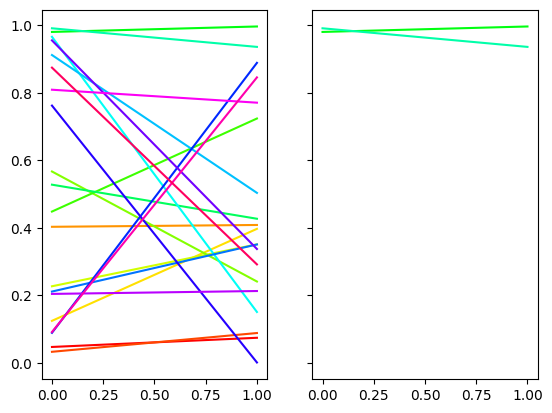

In [73]:
import matplotlib.pyplot as plt
from matplotlib import cm

f,a = plt.subplots(ncols=2, sharey=True)

for i in range(65,85):
    a[0].plot([0,1], [x[chr(i)], y[chr(i)]], label=chr(i), color=cm.hsv((i-65)/20))
    if chr(i) in x_hat.keys():
        a[1].plot([0,1], [x[chr(i)], y[chr(i)]], label=chr(i), color=cm.hsv((i-65)/20))

# a[0].legend()